In [1]:
import numpy as np
import gym
from cv2 import resize, INTER_CUBIC
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Activation
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from time import time, sleep

np.random.seed(0)

Using TensorFlow backend.


In [0]:
env_name = "AirRaid-v0"

env = gym.make(env_name)
s0 = env.reset()

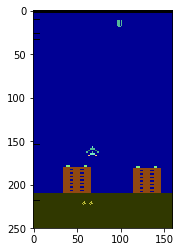

In [3]:
plt.imshow(s0)

In [0]:
gamma = 0.99 # discount factor
max_epsilon = 1 # initial exploration rate
min_epsilon = 0.1 # minimum exploration rate
Na = env.action_space.n # environment number of possible actions

img_size = (84, 84)

In [0]:
class replay_buffer:
  def __init__(self, N):
    self.N      = N # N is the buffer size
    self.buffer = []
    
  def add_transition(self, s1, a, r, s2, done):
    if len(self.buffer)<self.N:
      self.buffer.append((s1, a, r, s2, done))
    
    else:
      self.buffer.remove(self.buffer[0])
      self.buffer.append((s1, a, r, s2, done))
  
  def sample_batch(self, bsize):
    indices = np.random.choice(len(self.buffer), bsize, replace = False)
    
    states     = []
    actions    = []
    rewards    = []
    new_states = []
    dones      = []
    
    for ind in indices:
      state1   = self.buffer[ind][0]
      action   = self.buffer[ind][1]
      reward   = self.buffer[ind][2]
      state2   = self.buffer[ind][3]
      done     = self.buffer[ind][4]
      
      states.append(state1)
      actions.append(action)
      rewards.append(reward)
      new_states.append(state2)
      dones.append(done)
      
    return states, actions, rewards, new_states, dones

In [0]:
class DQN_model:
  def __init__(self, Na):
    self.q_network = self.create_network(Na)
    self.target_network = self.create_network(Na)
    self.update_target_network()
    
    
  def create_network(self, Na):
    model = Sequential()
    model.add(Conv2D(16, 8, strides=4, data_format="channels_last", activation="relu", kernel_initializer=RandomNormal(stddev=1e-03), input_shape = (84, 84, 4))) 
    model.add(Conv2D(32, 4, strides=2, data_format="channels_last", activation="relu", kernel_initializer=RandomNormal(stddev=1e-03)))
    model.add(Flatten())
    Dense(256, activation="relu", kernel_initializer=RandomNormal(stddev=1e-06))
    model.add(Dense(256, activation="relu", kernel_initializer=RandomNormal(stddev=1e-03)))
    model.add(Dense(Na, kernel_initializer=RandomNormal(stddev=1e-03)))
    model.compile(loss='mse',optimizer=RMSprop(lr=1e-03))
    return model
    
  def train_q_network_on_batch(self, states, q_values):
    self.q_network.fit(x = states, y = q_values, epochs = 2, batch_size = len(states), verbose = 0)
    
  def update_target_network(self):
    self.target_network.set_weights(self.q_network.get_weights())
    

In [7]:
dqn = DQN_model(Na)
RB = replay_buffer(1e06)

W0701 20:54:25.534014 139688155309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 20:54:25.551470 139688155309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 20:54:25.554687 139688155309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0701 20:54:25.631500 139688155309952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0701 20:54:25.727307 139688155309952 deprecation_wrapper.

In [0]:
n_episodes = 1000 # number of training episodes
max_steps = 1000 # maximum number of steps in a training episode
update_targets_every = 100 # steps to update the target network 

In [0]:
def choose_action(state, epsilon):
  u = np.random.rand()
  
  if u < epsilon:
    return np.random.choice(Na)
    
  pred = dqn.q_network.predict(np.array([state]))
  
  return np.argmax(pred.reshape(-1))

In [0]:
def preprocess_obs(obs1, obs2, first):
  resized1 = resize(obs1, dsize=img_size, interpolation=INTER_CUBIC)
  gray1 = resized1.mean(axis = 2)
  
  resized2 = resize(obs2, dsize=img_size, interpolation=INTER_CUBIC)
  gray2 = resized2.mean(axis = 2)
  
  if first:
    return np.stack([gray1, gray1, gray1, gray1], axis = 2), np.stack([gray1, gray1, gray1, gray2], axis = 2)
  
  state = RB.buffer[-1][0].copy()
  state[:,:,:3] = state[:,:,1:]
  state[:,:,-1] = gray1
  
  
  next_state = state.copy()
  next_state[:,:,:3] = next_state[:,:,1:]
  next_state[:,:,-1] = gray2
  
  return state, next_state

In [0]:
def decay_epsilon(step):
  return max(max_epsilon - 9*10**(-7)*step, min_epsilon)

In [0]:
batch_size = 32

step = 0
for episode in range(n_episodes):
  total_reward = 0
  obs = env.reset()
  first = True
  state, _ = preprocess_obs(obs, obs, first)
  
  for episode_step in range(max_steps):
    
    epsilon = decay_epsilon(step)
    
    action = choose_action(state, epsilon)
    
    new_obs, reward, done, _ = env.step(action)
    
    total_reward += reward
    
    state, new_state = preprocess_obs(obs, new_obs, first)
    
    RB.add_transition(state, action, reward, new_state, done)
    
    n_samples = min(len(RB.buffer), batch_size)
    
    states, actions, rewards, new_states, dones = RB.sample_batch(bsize = n_samples)
    
    target_q_vals = dqn.target_network.predict(np.array(states))
    
    for i in range(n_samples):
      if dones[i]:
        target_q_vals[i, actions[i]] = rewards[i]
        
      else:
        temp = dqn.target_network.predict(np.array([new_states[i]]))
        target_q_vals[i, actions[i]] = rewards[i] + gamma*np.amax(temp)
        
    dqn.train_q_network_on_batch(np.array(states), target_q_vals)
    
    if step>0 and step%update_targets_every==0:
      dqn.update_target_network()
      
      
    
    obs = new_obs
    
    first = False
    
    step += 1
    if done or (episode_step == max_steps - 1):
      print("Episode {} / {} : steps = {} , total reward = {}".format(episode, n_episodes, episode_step, total_reward))
      if done:
        break
  

Episode 0 / 1000 : steps = 387 , total reward = 375.0
Episode 1 / 1000 : steps = 801 , total reward = 325.0


In [0]:
dqn.q_network.save("q.h5")
dqn.target_network.save("taget.h5")
